In [20]:
import glob
import cv2
from cv2 import cvtColor
import matplotlib.pyplot as plt
import numpy as np
from moviepy.editor import VideoFileClip
from moviepy.editor import *
from IPython.display import HTML
from PIL import Image
%matplotlib inline

In [24]:
#upload test photo
test1 = plt.imread('test_images/test1.jpg')
test11 = cv2.imread('test_images/test1.jpg')
test2 = plt.imread('test_images/test2.jpg')
test22 = cv2.imread('test_images/test2.jpg')
test3 = plt.imread('test_images/test5.jpg')
test33 = cv2.imread('test_images/test5.jpg')
cv2.imshow('test',test11)
cv2.waitKey(0)
cv2.destroyAllWindows

<function destroyAllWindows>

# Define some useful functions

In [25]:
def show_image(image, title = 'image', cmap_type = 'gray'):
    plt.imshow(image, cmap = cmap_type)
    plt.title(title)

    
def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img,(kernel_size,kernel_size),0)
    

def getSrcDstPoints(img):
    width = img.shape[1]
    height = img.shape[0]

    src1 = (width*2/5, height*2/3)
    src2 = (width*3/5, height*2/3)
    src3 = (width*5/6, height)
    src4 = (width/6, height)
    src = np.float32([src1, src2, src3, src4])

    dst1 = (320, 0)
    dst2 = (width - 320, 0)
    dst3 = (width - 320, height)
    dst4 = (320, height)
    dst = np.float32([dst1, dst2, dst3, dst4])
    
    return src , dst


    # Destination points (to be incorporated as parameters to the final solution)
    dst1 = (320, 0)
    dst2 = (width - 320, 0)
    dst3 = (width - 320, height)
    dst4 = (320, height)
    dst = np.float32([dst1, dst2, dst3, dst4])
    
    return src , dst

def get_M_Minv(sourcePints, destinationPoints):
  
    M = cv2.getPerspectiveTransform(sourcePints, destinationPoints)
    Minv = cv2.getPerspectiveTransform(destinationPoints, sourcePints)
    
    return M, Minv


def warp_image(img, M):

    # get the size of the image
    width = img.shape[1]
    height = img.shape[0]
    # Apply the transformation    
    warped_image = cv2.warpPerspective(img, M, (width,height))
    #warped_image = warped(img, M, (width,height))

    return warped_image


# Image perspective transform

Text(0.5, 1.0, 'Warped (Bird eye view)')

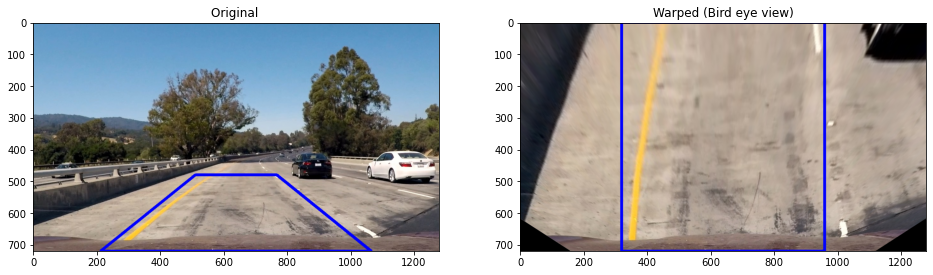

In [28]:
src , dst = getSrcDstPoints(test11)
M, _ = get_M_Minv(src , dst)
warped = warp_image(test11, M)
warped_copy = warped.copy()
region_of_interest2 = (dst.reshape((-1, 1, 2))).astype(np.int32)
cv2.polylines(warped_copy,[region_of_interest2], True, (255,0,0),  8)
region_of_interest = (src.reshape((-1, 1, 2))).astype(np.int32)
copy_img = test11.copy()
cv2.polylines(copy_img,[region_of_interest], True,  (255,0,0), 8)
figure, axs = plt.subplots(1, 2, figsize = (16, 16))
axs = axs.ravel()
axs[0].imshow(cv2.cvtColor(copy_img, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original ', fontsize = 12)
axs[1].imshow(cv2.cvtColor(warped_copy, cv2.COLOR_BGR2RGB))   
axs[1].set_title('Warped (Bird eye view)', fontsize = 12)

## Extract Color Channels

In [29]:
def get_rgb(img):
    #channel R has useful information
    r = img[:, :, 2]
    g = img[:, :, 1]
    b = img[:, :, 0]    
    return r, g, b

def get_hls(img):
    #channel l and s have useful information
    img_HLS = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    h = img_HLS[:, :, 0]
    l = img_HLS[:, :, 1]
    s = img_HLS[:, :, 2]
    
    return h, l , s

def get_lab(img):
    #channel b has useful information
    img_LAB = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
    l = img_LAB[:,:,0]
    a = img_LAB[:,:,1]
    b = img_LAB[:,:,2]
    
    return l, a, b
    
def combined_color_channels_threshod(img, r_thresh=(225,255), l_thresh=(215,255), s_thresh=(170,255), b_thresh=(180,255)):

    _, l, s = get_hls(img)
    r, _, _ = get_rgb(img)
    _, _, b = get_lab(img)
    # Create binary mask
    color_binary = np.zeros_like(r)
    # Combine the mask with the desired channels (R, S, L, B) (apply threshold)
    color_binary[((r > r_thresh[0]) & (r <= r_thresh[1])) |
                 ((l > l_thresh[0]) & (l <= l_thresh[1])) | 
                 ((s > s_thresh[0]) & (s <= s_thresh[1])) |
                 ((b > b_thresh[0]) & (b <= b_thresh[1])) ] = 1
    
    return color_binary   

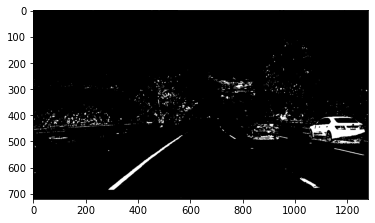

In [30]:
color_binary = combined_color_channels_threshod(test1)
plt.imshow(color_binary, cmap = 'gray')


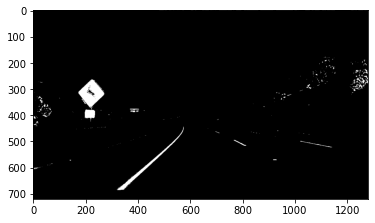

In [31]:
color_binary = combined_color_channels_threshod(test2)
plt.imshow(color_binary, cmap = 'gray')


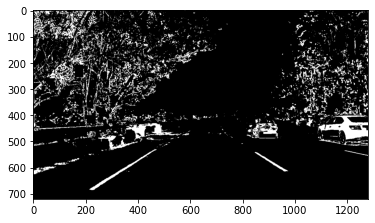

In [32]:
color_binary = combined_color_channels_threshod(test3)
plt.imshow(color_binary, cmap = 'gray')


## Sobel

In [33]:
def abs_sobel_thresh(img, axes = 'x', kernel = 3, thresh = (0, 255)):
    
    # get the image in gray
    gray_img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    if(axes == 'x'):
        # Apply sobel edge detection in x direction
        sobel = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize = kernel)
    else:
        # Apply sobel edge detection in y direction
        sobel = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize = kernel)
    # Take the absolute value
    abs_sobel = np.absolute(sobel)
    # Rescale the intensities
    scaled_sobel = (255 * abs_sobel / np.max(abs_sobel)).astype(np.uint8) 
    # Create binary mask
    grad_binary = np.zeros_like(scaled_sobel)
    # Combine the mask with the x or y gradient (apply threshold)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
 
    return grad_binary

In [34]:
def mag_sobel_threshold(img , kernel = 3, thresh = (0, 255)):

    gray_img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # Apply sobel edge detection in x and y directions
    sobelx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize = kernel)
    sobely = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize = kernel)
    
    # Get the pixels magnitude
    
    magnitude = np.sqrt(sobelx ** 2 + sobely ** 2) 
    
    # Rescale the intensities
    
    scaled_magnitude = ((255 * magnitude) / np.max(magnitude)).astype(np.uint8) 
    
    # Create binary mask
    
    mag_binary = np.zeros_like(scaled_magnitude)
    
    # Combine the mask with the scaled magnitude (apply threshold)
    
    mag_binary[(scaled_magnitude >= thresh[0]) & (scaled_magnitude <= thresh[1])] = 1
    
    return mag_binary

    

In [35]:
def dir_sobel_threshold(img, kernel = 3, thresh = (0, np.pi/2)):
    
    # get the image in gray
    
    gray_img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

    # Calculate the x and y gradients
    
    sobelx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize = kernel)
    sobely = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize = kernel)
    
    # Take the absolute value
    abs_dir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    
    # Create binary mask
    
    dir_binary =  np.zeros_like(abs_dir)
    
    # Combine the mask with the absolute direction value (apply threshold)
    
    dir_binary[(abs_dir >= thresh[0]) & (abs_dir <= thresh[1])] = 1
    
    return dir_binary



In [36]:
def combined_grad_color_threshold(img,grad_kernel = 3, gradx_thresh = (20,100), grady_thresh = (50,100),mag_kernel = 5, mag_thresh = (50,100),dir_kernel = 9, dir_thresh = (0.7,1.3)):
    
    color_binary = combined_color_channels_threshod(img)
    gray_img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # Apply sobel edge detection in x and y directions
    gradx = abs_sobel_thresh(img, 'x', grad_kernel, gradx_thresh)
    grady = abs_sobel_thresh(img, 'y', grad_kernel, grady_thresh)
    # get mag_sobel_threshold
    mag_binary = mag_sobel_threshold(img, mag_kernel, mag_thresh)
    # get dir_sobel_threshold
    dir_binary = dir_sobel_threshold(img, dir_kernel, dir_thresh)
    # Combined color channels and gradient in y and x and it directions and magnitudes (apply threshold)
    combined_binary = np.zeros_like(color_binary)
    combined_binary[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (color_binary == 1)] = 1
    
    return combined_binary

Text(0.5, 1.0, 'Color combined_grad_color_threshold)')

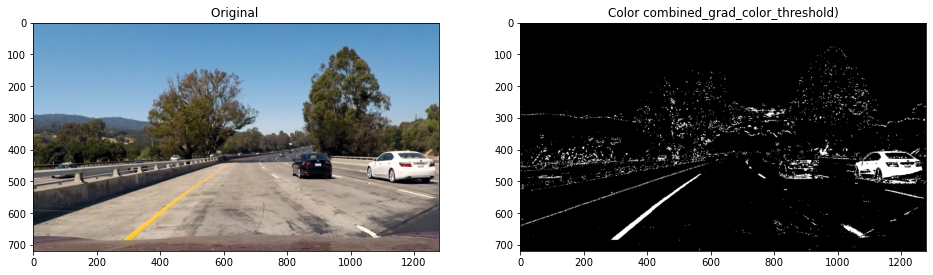

In [37]:
color_binary = combined_grad_color_threshold(test1)
fig, axs = plt.subplots(1, 2, figsize = (16, 16))
axs = axs.ravel()
axs[0].imshow(cv2.cvtColor(test11, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original ', fontsize = 12)
axs[1].imshow(color_binary, cmap='gray')
axs[1].set_title('Color combined_grad_color_threshold)', fontsize = 12)

Text(0.5, 1.0, 'Color combined_grad_color_threshold)')

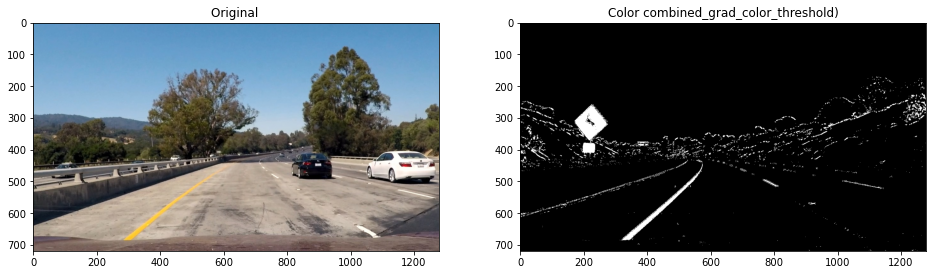

In [38]:
color_binary = combined_grad_color_threshold(test2)
fig, axs = plt.subplots(1, 2, figsize = (16, 16))
axs = axs.ravel()
axs[0].imshow(cv2.cvtColor(test11, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original ', fontsize = 12)
axs[1].imshow(color_binary, cmap='gray')
axs[1].set_title('Color combined_grad_color_threshold)', fontsize = 12)

Text(0.5, 1.0, 'Color combined_grad_color_threshold)')

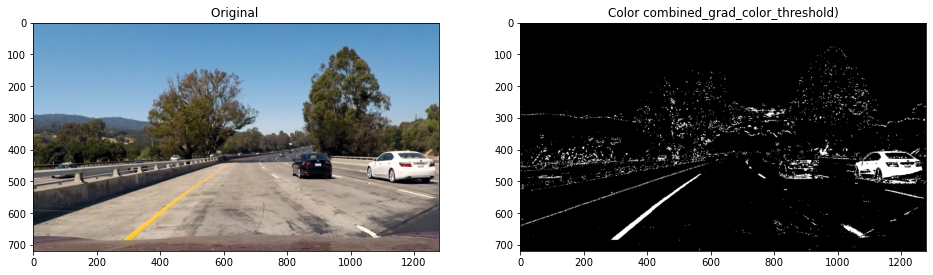

In [39]:
color_binary = combined_grad_color_threshold(test1)
fig, axs = plt.subplots(1, 2, figsize = (16, 16))
axs = axs.ravel()
axs[0].imshow(cv2.cvtColor(test11, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original ', fontsize = 12)
axs[1].imshow(color_binary, cmap='gray')
axs[1].set_title('Color combined_grad_color_threshold)', fontsize = 12)

# Apply Canny Edge Detection

In [40]:

def auto_canny_threshould(image, sigma=0.33):
    
    # Apply bluring to iliminate the noise
    img_blured = gaussian_blur(image, 7)
    # compute the median of the single channel pixel intensities
    v = np.median(img_blured)
    # apply automatic Canny edge detection using the computed median
    lower_threshold = int(max(0, (1.0 - sigma) * v))
    upper_threshold = int(min(255, (1.0 + sigma) * v))
    # apply canny edge detection
    canny_edged = cv2.Canny(img_blured, lower_threshold, upper_threshold)
    # return the edged image
    return canny_edged

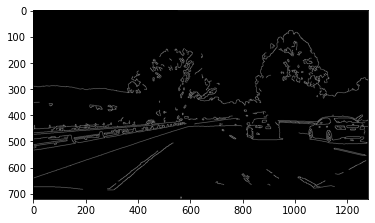

In [41]:
canny_test = auto_canny_threshould(test1)
plt.imshow(canny_test, cmap = 'gray')

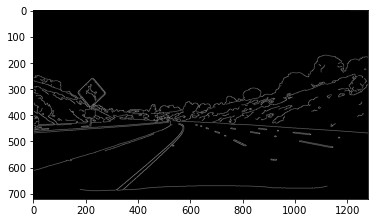

In [42]:
canny_test = auto_canny_threshould(test2)
plt.imshow(canny_test, cmap = 'gray')

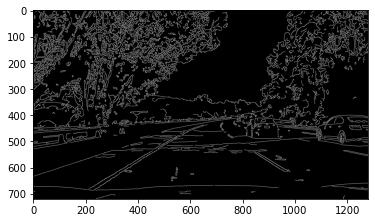

In [43]:
canny_test = auto_canny_threshould(test3)
plt.imshow(canny_test, cmap = 'gray')

### Combining all together

In [44]:
def combined_canny_grad_color_threshold(img):

    color_grad_binary = combined_grad_color_threshold(img)
    canny_edged = auto_canny_threshould(img)
    combined_binary = np.zeros_like(color_grad_binary)
    combined_binary[ (canny_edged == 1) | (color_grad_binary == 1)] = 1
    
    return combined_binary

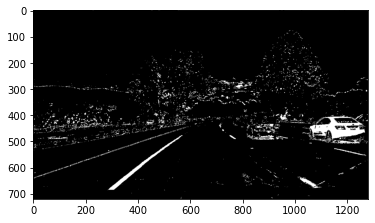

In [45]:
binary = combined_canny_grad_color_threshold(test1)
plt.imshow(binary, cmap = 'gray')

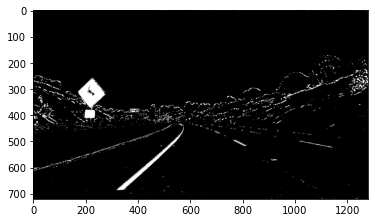

In [46]:
binary = combined_canny_grad_color_threshold(test2)
plt.imshow(binary, cmap = 'gray')

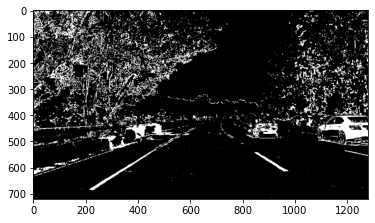

In [47]:
binary = combined_canny_grad_color_threshold(test3)
plt.imshow(binary, cmap = 'gray')

# Apply Perspective Transform to Binary Image

Text(0.5, 1.0, 'Warped (Bird eye view)')

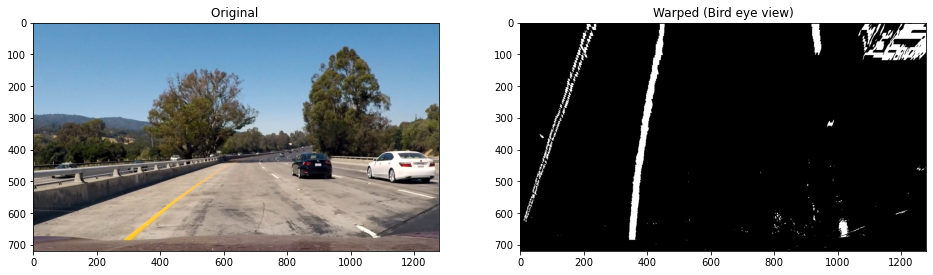

In [51]:
binary = combined_canny_grad_color_threshold(test1)
warped = warp_image(binary, M)
figure, axs = plt.subplots(1, 2, figsize = (16, 16))
axs = axs.ravel()
axs[0].imshow(test1)
axs[0].set_title('Original ', fontsize = 12)
axs[1].imshow(warped, cmap = 'gray')   
axs[1].set_title('Warped (Bird eye view)', fontsize = 12)

Text(0.5, 1.0, 'Warped (Bird eye view)')

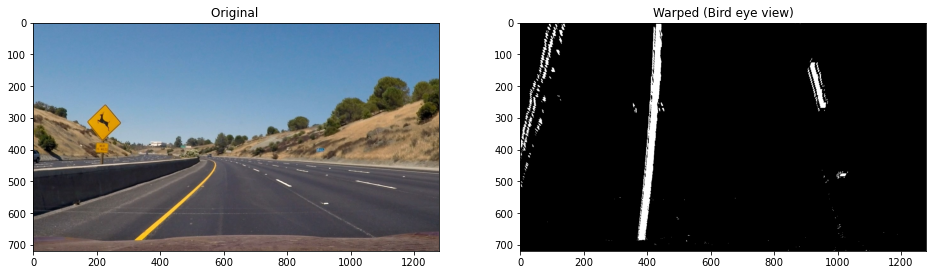

In [52]:
binary = combined_canny_grad_color_threshold(test2)
warped = warp_image(binary, M)
figure, axs = plt.subplots(1, 2, figsize = (16, 16))
axs = axs.ravel()
axs[0].imshow(test2)
axs[0].set_title('Original ', fontsize = 12)
axs[1].imshow(warped, cmap = 'gray')   
axs[1].set_title('Warped (Bird eye view)', fontsize = 12)

Text(0.5, 1.0, 'Warped (Bird eye view)')

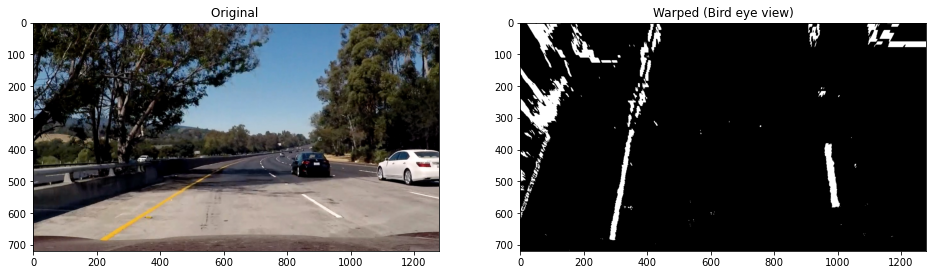

In [54]:
binary = combined_canny_grad_color_threshold(test3)
warped = warp_image(binary, M)
figure, axs = plt.subplots(1, 2, figsize = (16, 16))
axs = axs.ravel()
axs[0].imshow(test3)
axs[0].set_title('Original ', fontsize = 12)
axs[1].imshow(warped, cmap = 'gray')   
axs[1].set_title('Warped (Bird eye view)', fontsize = 12)

# Extract a Histogram

In [55]:
def get_histogram(img):
    bottom_half = img[img.shape[0]//2:,:]
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

In [56]:
def get_binary_warped(img, M):

    combined_img = combined_canny_grad_color_threshold(img)   
    # Apply transformation
    warped = warp_image(combined_img, M)

    return warped

In [57]:
def get_histogram_peaks(img):


    histogram_of_img = get_histogram(img)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram_of_img.shape[0]//2)
    leftx_base = np.argmax(histogram_of_img[:midpoint])
    # np.argmax() Returns the indices of the maximum values along an axis.
    rightx_base = np.argmax(histogram_of_img[midpoint:]) + midpoint
    
    return leftx_base, rightx_base

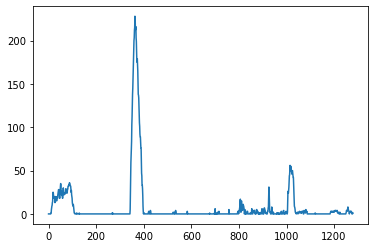

In [58]:
warped = get_binary_warped(test1, M)
histogramm = get_histogram(warped)
plt.plot(histogramm)


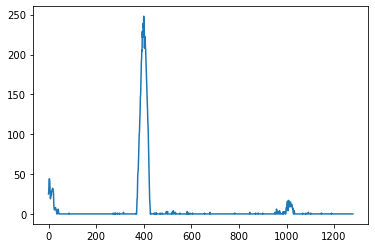

In [60]:
warped = get_binary_warped(test2, M)
histogramm = get_histogram(warped)
plt.plot(histogramm)


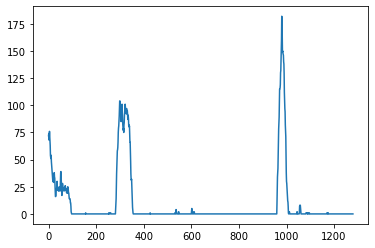

In [61]:
warped = get_binary_warped(test3, M)
histogramm = get_histogram(warped)
plt.plot(histogramm)


# Apply Sliding Window Algorithm

In [62]:
# this algorithm return list of pixels that can be used to fit a polinomio that correspond with the lines (left and rigth)
# this method is used only at the beginning or if the tracking systema lost the lane lines.
def Sliding_Window_lines_positions(warped, no_of_windows = 10, margin = 100, minpix = 20):

    leftx_base, rightx_base = get_histogram_peaks(warped)   
    window_height = np.int(warped.shape[0]//no_of_windows)#1280//10 = 128
    # nonzero() Returns a tuple of arrays, for x and y, containing the indices of the non-zero elements
    non_zero = warped.nonzero()
    non_zero_y = np.array(non_zero[0])
    non_zero_x = np.array(non_zero[1])
    
    # Start with the returned indicies of the histogram and will be updated later
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    right_windows = []
    left_windows = []
    
    # Step through the windows one by one
    for window in range(no_of_windows):
        # Identify window boundaries in x and y (and right and left)
        W_lower_limit_y = warped.shape[0] - (window + 1) * window_height# 592
        W_higher_limit_y = warped.shape[0] - window * window_height#720
        W_xleft_low = leftx_current - margin#315 - 100 = 215
        W_xleft_high = leftx_current + margin#315 + 100 = 415
        W_xright_low = rightx_current - margin#958 -100 = 858
        W_xright_high = rightx_current + margin#958+100=1058
        
        
        # Append windows corners used during the sliding (to visualizaton rectanguler windows)
        # The append() method appends an element to the end of the list.
        left_windows.append(((W_xleft_low, W_lower_limit_y), (W_xleft_high, W_higher_limit_y)))
        
        
        right_windows.append(((W_xright_low, W_lower_limit_y), (W_xright_high, W_higher_limit_y)))
        
        # Identify the nonzero pixels in x and y within the window 
        good_left_inds = ((non_zero_y >= W_lower_limit_y) & (non_zero_y < W_higher_limit_y) &                          
                          (non_zero_x >= W_xleft_low) &  (non_zero_x < W_xleft_high)).nonzero()[0]
        good_right_inds = ((non_zero_y >= W_lower_limit_y) & (non_zero_y < W_higher_limit_y) & 
                           (non_zero_x >= W_xright_low) &  (non_zero_x < W_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If there is number of nonzeros pixels > minpix, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(non_zero_x[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(non_zero_x[good_right_inds]))
            
                # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass
    
        # Extract left and right line pixel positions
    leftx = non_zero_x[left_lane_inds]
    lefty = non_zero_y[left_lane_inds] 
    rightx = non_zero_x[right_lane_inds]
    righty = non_zero_y[right_lane_inds]


    return leftx, lefty, rightx, righty

In [63]:
def Fitting_Lines_Curves_eqns(warped,leftx, lefty, rightx, righty):
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )#0,1,2,......,719
    
    # np.polyfit Returns a vector of coefficients p that minimises the squared error in the order deg, deg-1, … 0.
    left_fit = np.polyfit(lefty, leftx, 2)#y,x,degree of poly
    right_fit = np.polyfit(righty, rightx, 2)#y,x,degree of poly
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]# x = a2 * y^2 + a1 * y + a0
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    y_eval = np.max(ploty)  # 720p video/image, so last (lowest on screen) y index is 719

    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curv = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curv = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_fit, right_fit, left_fitx, right_fitx, left_curv, right_curv

In [64]:
def Get_Exact_Lines_Positions(warped, left_fit, right_fit, sap_margin =70):

    # Grab activated pixels
    non_zero = warped.nonzero()
    non_zero_y = np.array(non_zero[0])
    non_zero_x = np.array(non_zero[1])
    
    # Identify the nonzero pixels in x and y within the window
    left_lane_inds = ((non_zero_x > (left_fit[0] * (non_zero_y**2) + left_fit[1] * non_zero_y + 
                    left_fit[2] - sap_margin)) & (non_zero_x < (left_fit[0] * (non_zero_y**2) + 
                    left_fit[1]*non_zero_y + left_fit[2] + sap_margin)))
    right_lane_inds = ((non_zero_x > (right_fit[0] * (non_zero_y**2) + right_fit[1] * non_zero_y + 
                    right_fit[2] - sap_margin)) & (non_zero_x < (right_fit[0] * (non_zero_y**2) + 
                    right_fit[1] * non_zero_y + right_fit[2] + sap_margin)))
    
    # Again, extract left and right line pixel positions
    leftx_line_pos = non_zero_x[left_lane_inds]
    lefty_line_pos = non_zero_y[left_lane_inds] 
    rightx_line_pos = non_zero_x[right_lane_inds]
    righty_line_pos = non_zero_y[right_lane_inds]
    
    return leftx_line_pos, lefty_line_pos, rightx_line_pos, righty_line_pos

# Draw Lane Line on Image

In [65]:
def Draw_Lines_on_img(img, Minv, left_fitx, right_fitx):

    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    height, width = img.shape[:2]
    # Prepare the image to map the lane
    warp_black = np.zeros((height, width)).astype(np.uint8)
    warp_color = np.dstack((warp_black, warp_black, warp_black))
    # Calculate the left and the right x,y position of the boundaries
    left_line = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    right_line = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])    
    lane = np.hstack((left_line, right_line))
    # Draw the lane
    cv2.fillPoly(warp_color, np.int_([lane]), (0,255, 0))
    cv2.polylines(warp_color, np.int32([left_line]), isClosed=False, color=(0,0,255), thickness=15)
    cv2.polylines(warp_color, np.int32([right_line]), isClosed=False, color=(0,0,255), thickness=15)
    # Unwarp the image to be merge with the original frame
    unWarpLane = cv2.warpPerspective(warp_color, Minv, (width, height)) 
    # Merge the lane with the original picture
    img_with_lane = cv2.addWeighted(img, 1, unWarpLane, 0.8, 0)
    
    return img_with_lane, warp_color

# Write lane informarion

In [66]:
def Write_Information_on_img(img, leftx_base, rightx_base ,left_curv, right_curv):

    copy_img = np.copy(img)
    h = copy_img.shape[0]
    car_position = copy_img.shape[1]/2
    lane_center_position = leftx_base + (rightx_base - leftx_base)/2
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # can be changed

    center_distance = (car_position - lane_center_position) * xm_per_pix
    
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Radius of Curvature: ' + '{:04.2f}'.format((left_curv + right_curv)/2) + ' m'
    cv2.putText(copy_img, text, (40,70), font, 1, (255,255,255), 2, cv2.LINE_AA)
    text = 'Position: ' + '{:04.2f}'.format(center_distance) + ' m from center of lane'
    cv2.putText(copy_img, text, (40,120), font, 1, (255,5255,255), 2, cv2.LINE_AA)
    
    return copy_img

# Piplines

In [67]:
def binary_warped_pipeline(img):
    image_height = img.shape[0]
    image_width = img.shape[1]
    src , dst = getSrcDstPoints(img)
    M , Minv = get_M_Minv(src, dst)
    out = get_binary_warped(img, M)
    img = np.zeros((3, image_height, image_width))
    img[0] = out
    img[1] = out
    img[2] = out
    nn = np.moveaxis(img, 0, -1)
    out2 = cv2.cvtColor(nn.astype('uint8') * 255, cv2.COLOR_BGR2GRAY)
    img2 = np.zeros((3, image_height, image_width))
    img2[0] = out2
    img2[1] = out2
    img2[2] = out2
    return np.moveaxis(img2, 0, -1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


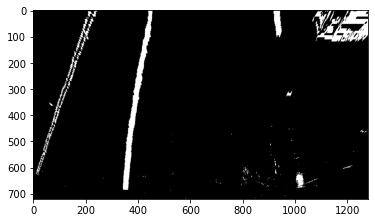

In [68]:
plt.imshow(binary_warped_pipeline(test1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


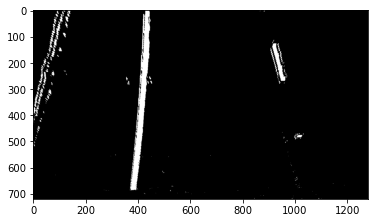

In [69]:
plt.imshow(binary_warped_pipeline(test2))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


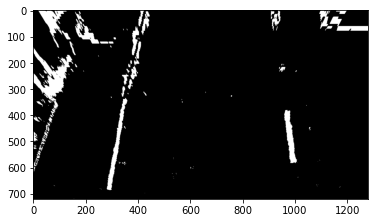

In [70]:
plt.imshow(binary_warped_pipeline(test3))

In [71]:
def threshold_pipeline(img):
    image_height = img.shape[0]
    image_width = img.shape[1]
    out = combined_canny_grad_color_threshold(img)
    img = np.zeros((3, image_height, image_width))
    img[0] = out
    img[1] = out
    img[2] = out
    nn = np.moveaxis(img, 0, -1)
    out2 = cv2.cvtColor(nn.astype('uint8') * 255, cv2.COLOR_BGR2GRAY)
    img2 = np.zeros((3, image_height, image_width))
    img2[0] = out2
    img2[1] = out2
    img2[2] = out2
    return np.moveaxis(img2, 0, -1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


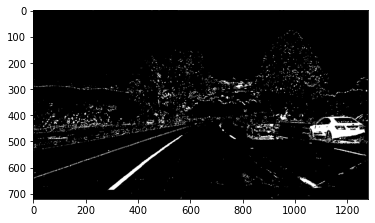

In [72]:
plt.imshow(threshold_pipeline(test1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


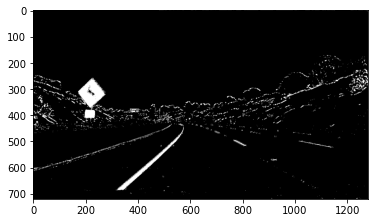

In [73]:
plt.imshow(threshold_pipeline(test2))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


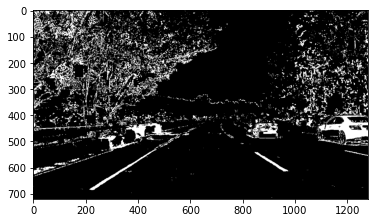

In [74]:
plt.imshow(threshold_pipeline(test3))

In [75]:
def drawn_warped_pipeline(img):
    image_height = img.shape[0]
    image_width = img.shape[1]
    src , dst = getSrcDstPoints(img)
    M , Minv = get_M_Minv(src, dst)
    warped2 = warp_image(img,M)
    warped  = get_binary_warped(img, M)
    leftx_base, rightx_base = get_histogram_peaks(warped)
    leftx, lefty, rightx, righty = Sliding_Window_lines_positions(warped, no_of_windows = 10, margin = 100, minpix = 20)
    left_fit, right_fit, left_fitx, right_fitx, left_curv, right_curv = Fitting_Lines_Curves_eqns(warped,leftx, lefty, rightx, righty)
    leftx2, lefty2, rightx2, righty2 = Get_Exact_Lines_Positions(warped, left_fit, right_fit)
    left_fit2, right_fit2, left_fitx2, right_fitx2, left_curv2, right_curv2 = Fitting_Lines_Curves_eqns(warped,leftx, lefty, rightx, righty)

    img2,out = Draw_Lines_on_img(img, Minv, left_fitx2, right_fitx2)
    out2 = cv2.addWeighted(warped2, 1, out, 0.8, 0)
    return out2


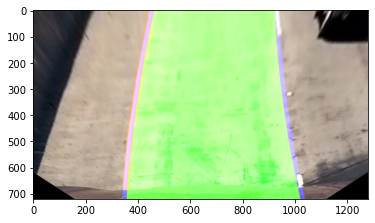

In [76]:
plt.imshow(drawn_warped_pipeline(test1))

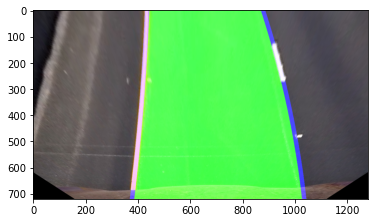

In [77]:
plt.imshow(drawn_warped_pipeline(test2))

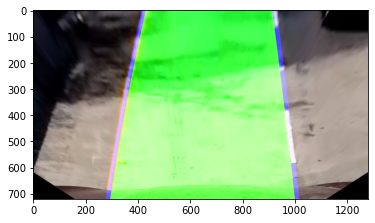

In [78]:
plt.imshow(drawn_warped_pipeline(test3))

In [79]:
def Main_pipeline(img):
    src , dst = getSrcDstPoints(img)
    M , Minv = get_M_Minv(src, dst)
    warped  = get_binary_warped(img, M)
    leftx_base, rightx_base = get_histogram_peaks(warped)
    leftx, lefty, rightx, righty = Sliding_Window_lines_positions(warped, no_of_windows = 10, margin = 100, minpix = 20)
    left_fit, right_fit, left_fitx, right_fitx, left_curv, right_curv = Fitting_Lines_Curves_eqns(warped,leftx, lefty, rightx, righty)
    leftx2, lefty2, rightx2, righty2 = Get_Exact_Lines_Positions(warped, left_fit, right_fit)
    left_fit2, right_fit2, left_fitx2, right_fitx2, left_curv2, right_curv2 = Fitting_Lines_Curves_eqns(warped,leftx, lefty, rightx, righty)

    img2,img3 = Draw_Lines_on_img(img, Minv, left_fitx2, right_fitx2)
    img2 = Write_Information_on_img(img2, leftx_base, rightx_base,left_curv2, right_curv2)
        
    #plt.imshow(img2)

    return img2

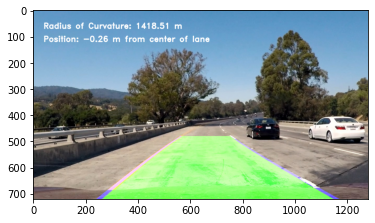

In [80]:
plt.imshow(Main_pipeline(test1))

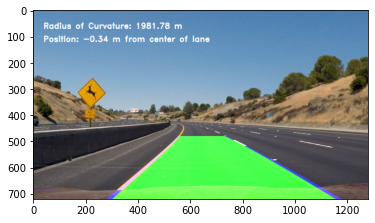

In [81]:
plt.imshow(Main_pipeline(test2))

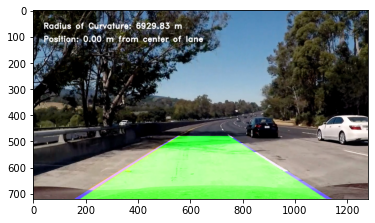

In [82]:
plt.imshow(Main_pipeline(test3))

In [83]:


def debug_img_pipeline(img):
    img1 = Image.fromarray(Main_pipeline(img).astype(np.uint8), 'RGB')
    img2 = Image.fromarray(drawn_warped_pipeline(img).astype(np.uint8), 'RGB') 
    img3 = Image.fromarray(threshold_pipeline(img).astype(np.uint8),'RGB') 
    img4 = Image.fromarray(binary_warped_pipeline(img).astype(np.uint8),'RGB') 
    size=img1.size
    img2=img2.resize((int(size[0]/3),int(size[1]*0.333)))
    img3=img3.resize((int(size[0]/3),int(size[1]*0.333)))
    img4=img4.resize((int(size[0]/3),int(size[1]*0.333)))
    image = Image.new('RGB',(int((4/3)*size[0]),int(size[1])), (255,255,255))
    image.paste(img1,(0,0))
    image.paste(img2,(int(size[0]),0))
    image.paste(img3,(int(size[0]),int(size[1]/3)))
    image.paste(img4,(int(size[0]),2*int(size[1]/3)))

    image_array = np.asarray(image)
    
    return image_array

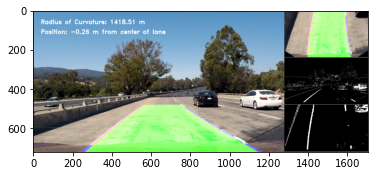

In [84]:
mm=debug_img_pipeline(test1)
plt.imshow(mm)

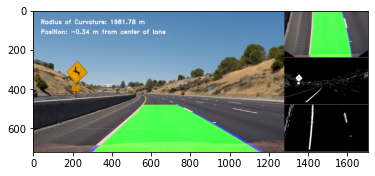

In [85]:
mm=debug_img_pipeline(test2)
plt.imshow(mm)

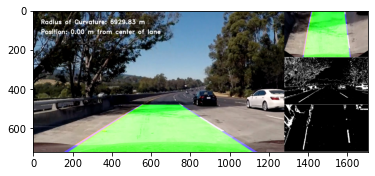

In [86]:
mm=debug_img_pipeline(test3)
plt.imshow(mm)

# Creating output image

In [87]:
def Create_img_lane_lines(input_path,output_path,debug = 0):
    img = plt.imread(input_path)
    if(debug == 1):
        new_img = debug_img_pipeline(img)
    else:
        new_img = Main_pipeline(img)
        
    #cv2.imwrite(output_path,new_img)
    new_img = Image.fromarray(new_img.astype(np.uint8), 'RGB')
    new_img.save(output_path)


# Creating output video

In [88]:
def Create_Video(input_path, output_path,debug=0, subclip = False, subtime = 0):
   if (debug==0):
       video_input = VideoFileClip(input_path)
       if(subclip == True):
            newclip = video_input.subclip(0,subtime)
            processed_video = newclip.fl_image(Main_pipeline)
       else:
            processed_video = video_input.fl_image(Main_pipeline)
   
       %time  processed_video.write_videofile(output_path, audio=False)
   elif(debug==1) :
       video_input = VideoFileClip(input_path)
       if(subclip == True):
           newclip = video_input.subclip(0,subtime)
           processed_video = newclip.fl_image(debug_img_pipeline)
       else:
           processed_video = video_input.fl_image(debug_img_pipeline)
   %time  processed_video.write_videofile(output_path, audio=False)